# News Articles Analysis

### Import the whole dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data.tsv", sep='\t', encoding = 'ANSI')

In [3]:
df.shape

(2225, 4)

# 1. Word Clouds per Category

In [2]:
from wordcloud import WordCloud

Generate a string containing all the words from a specific column of our dataframe:

In [4]:
def choose_category_content(category):
    articles_series = df[df['category'] == category]['content']
    words = ' '.join(articles_series)
    return words

Now we need to make a wordcloud generator for an article's category:

In [5]:
def wordcloud_gen(category):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "white",
        min_font_size = 10).generate(choose_category_content(category))

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Business Word Cloud

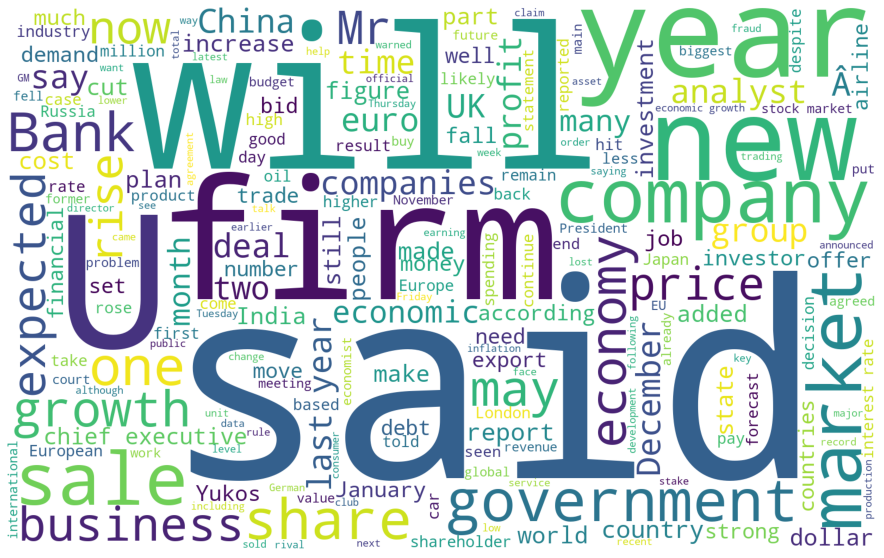

In [6]:
wordcloud_gen("business")

### Entertainment Word Cloud

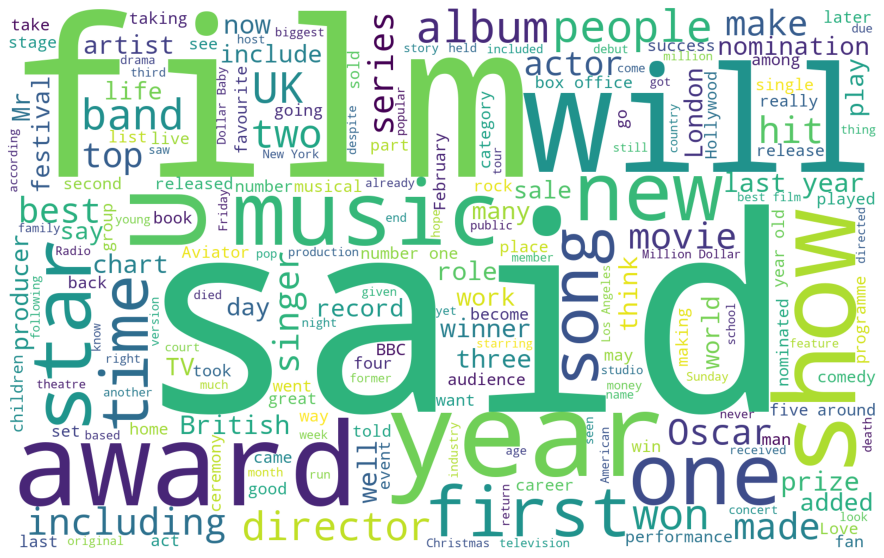

In [7]:
wc = wordcloud_gen("entertainment")

### Politics Word Cloud

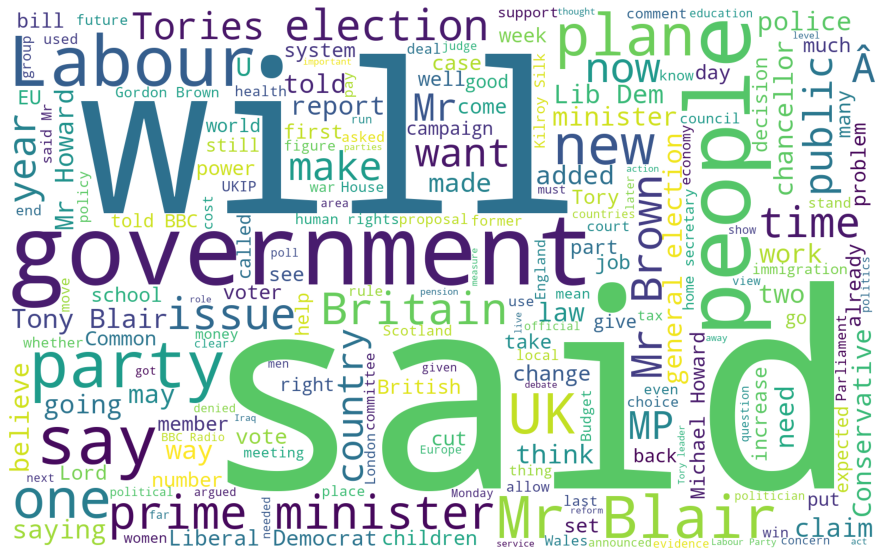

In [8]:
wc = wordcloud_gen("politics")

### Sport Word Cloud

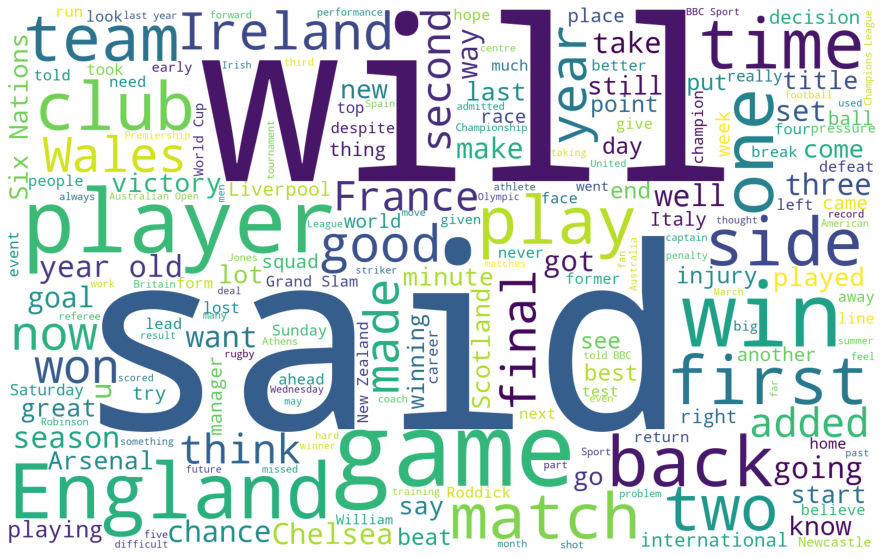

In [9]:
wc = wordcloud_gen("sport")

### Tech Word Cloud

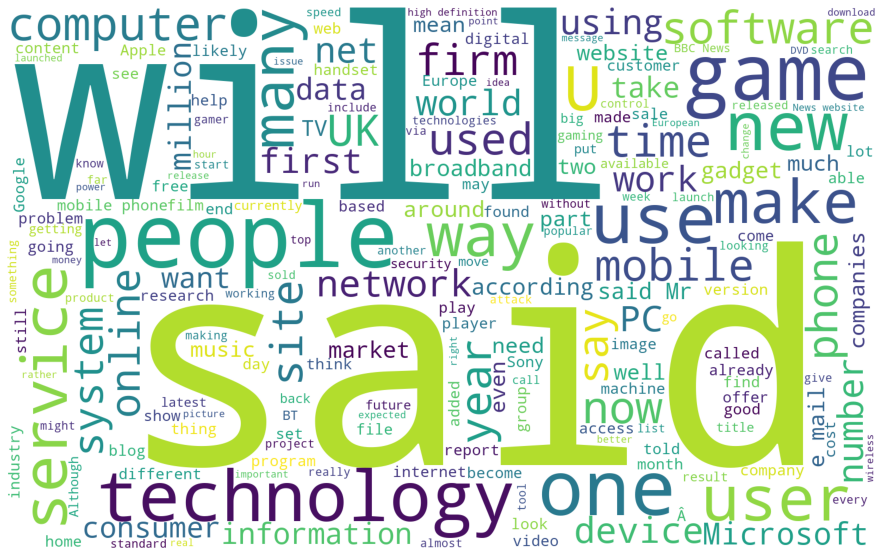

In [10]:
wordcloud_gen("tech")

# 2 Classification



### Load our test and train datasets.

In [11]:
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score       
                            
train_set = pd.read_csv("train_set.tsv", sep='\t', encoding = 'ANSI')
test_set = pd.read_csv("test_set.tsv", sep='\t', encoding = 'ANSI')
test_labels = pd.read_csv("test_labels.tsv", sep='\t', encoding = 'ANSI')

Keep only the content and category columns.

In [12]:
train_content = train_set['content']
train_labels = train_set['category']
test_content = test_set['content']
test_categories = test_labels['category']

### Encode the train and test labels using sklearn.preprocessing.LabelEncoder

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_categories)

## 2.1 Transform our text data using CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vec = CountVectorizer(max_features=1000,ngram_range=(1,2))

cv_train_content = count_vec.fit_transform(train_content)
cv_test_content = count_vec.transform(test_content)

### KNNClassifier prototype

Here i have implemented a simple classifier for the K Nearest Neighbor estimator. It uses the mahnattan distance metric to produce the distances between each article pair. But this estimator is not qualified for the sklearn's cross_validate function, so i tried to make one on my own.

In [15]:
from sklearn.metrics.pairwise import manhattan_distances
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split
class KNNClassifier():
    
    def __init__(self, k=5,verbose=False):
        self.n_neighbors = k
        self.verbose = verbose
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        
        final_output = []
        dis = manhattan_distances(X_test,self.X_train)
        """ For every document in the test set, find its k nearest other documents."""
        for i in range(X_test.shape[0]):
            k_nearest_indices = np.argpartition(dis[i], self.n_neighbors)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices].tolist()
            
            i_label = max(set(k_nearest_labels), key = k_nearest_labels.count)
            final_output.append(i_label)
        return final_output

def testOneFold(estimator,trainSet,testSet):
    tpCnt=0
    allCnt=0
    X_train, X_test, y_train, y_test = trainSet[:,0], testSet[:,0], trainSet[:,1], testSet[:,1]
    X_train, y_train = train_test_split(trainSet)
    X_train = sparse.csr_matrix(X_train)
    print(X_train.shape)
    clf = estimator
    clf.fit(trainSet,train_labels)
    predicts = clf.predict(testSet)
    print(precision_score(test_labels, knn_predicted_labels, average='macro'))
        

def cross_validation(estimator, X,Y,num_folds=5):
    print(type(X))
    train = np.array(list(zip(X,Y)))
    np.random.shuffle(train)
    foldsList = np.array_split(train, num_folds)
    
    for fold in range(num_folds):
        testSet = np.empty((0,train.shape[1]))
        trainSet = np.empty((0,train.shape[1]))
        
        for j in range(num_folds):
            if fold == j:
                testSet = foldsList[fold]
            else:
                trainSet = np.concatenate((trainSet, foldsList[j]), axis=0)
        score = testOneFold(estimator,trainSet,testSet)
        scores += [score]
    mean_score = sum(scores)/len(scores)
    return mean_score

### Classifiers cross validation and Evaluating predicted results.

In [16]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

### 2.1.1 Support Vector Machine (SVM)

First we perform a grid search to tune the model and see which parameters work best.

In [17]:
svm_clf = SVC()

param_grid = {
            'kernel': ['rbf', 'linear'],
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(svm_clf, param_grid)

Fit the train data into the grid search and show the best parameters for the SVM classifier.

In [18]:
clf.fit(cv_train_content, train_labels)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                         'kernel': ['rbf', 'linear']})

In [19]:
clf.best_params_

{'C': 1000.0, 'gamma': 0.0005, 'kernel': 'rbf'}

Once we've found the best parameters, use them to perform the cross validation and test evaluation.

In [20]:
svm_clf = SVC(kernel='rbf',C=1000, gamma=0.0001)
svm_clf.fit(cv_train_content, train_labels)

SVC(C=1000, gamma=0.0001)

Now perform a 10-Fold Cross Validation on the trained model.

In [21]:
svm_scores = cross_validate(svm_clf, cv_train_content, train_labels, scoring=scoring, cv=10)

In [22]:
for i in svm_scores:
    print(i,svm_scores[i].mean())

fit_time 0.6034920930862426
score_time 0.0747068166732788
test_precision_macro 0.9575311452245912
test_recall_macro 0.9543611306871652
test_f1_macro 0.9549164969861353
test_accuracy 0.95561797752809


We will proceed to predict the labels.

In [23]:
svm_predicted_labels = svm_clf.predict(cv_test_content)

In [24]:
print("precision:",precision_score(test_labels, svm_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, svm_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, svm_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, svm_predicted_labels))

precision: 0.9689929486168886
Recall: 0.9674726254138019
F1: 0.968004370470589
Accuracy: 0.9685393258426966


### 2.1.2 Random Forest Classifier

In [25]:
rf_clf = RandomForestClassifier()

In [26]:
rf_clf.fit(cv_train_content, train_labels)

RandomForestClassifier()

In [27]:
rf_scores = cross_validate(rf_clf, cv_train_content, train_labels, scoring=scoring, cv=10)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.796470046043396
score_time 0.017845511436462402
test_precision_macro 0.9650934626112366
test_recall_macro 0.9613575210965581
test_f1_macro 0.9626243114794895
test_accuracy 0.9634831460674157


In [28]:
rd_predicted_labels = rf_clf.predict(cv_test_content)

In [29]:
print("precision:",precision_score(test_labels, rd_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, rd_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, rd_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, rd_predicted_labels))

precision: 0.965915990605857
Recall: 0.9639712248535778
F1: 0.9646884423271851
Accuracy: 0.9640449438202248


### 2.1.3 Multinomial Naive Bayes

In [30]:
mnb_clf = MultinomialNB()

In [31]:
mnb_clf.fit(cv_train_content, train_labels)

MultinomialNB()

In [32]:
rf_scores = cross_validate(mnb_clf, cv_train_content, train_labels, scoring=scoring, cv=10)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.0023993253707885742
score_time 0.00319979190826416
test_precision_macro 0.9666030405079645
test_recall_macro 0.966193028423729
test_f1_macro 0.9659539204439197
test_accuracy 0.9668539325842695


In [33]:
mnb_predicted_labels = mnb_clf.predict(cv_test_content)

In [34]:
print("precision:",precision_score(test_labels, mnb_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, mnb_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, mnb_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, mnb_predicted_labels))

precision: 0.9763688659721492
Recall: 0.9795518207282914
F1: 0.9775494437489289
Accuracy: 0.9775280898876404


### 2.1.4 K Nearest Neighbours

In [35]:
knn_clf = KNNClassifier()
knn_clf.fit(cv_train_content,train_labels)
knn_predicted_labels = knn_clf.predict(cv_test_content)

In [36]:
print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.8372383240361116
Recall: 0.5474949070537306
F1: 0.5626351353440892
Accuracy: 0.5775280898876405


## 2.2 Transform our text data using TF-IDF Vectorizer

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=300, ngram_range=(1,2))

tfidf_train_content = tfidf_vec.fit_transform(train_content)
tfidf_test_content = tfidf_vec.transform(test_content)

### 2.2.1 Support Vector Machine (SVM)

In [38]:
param_grid = {
            'kernel': ['rbf', 'linear'],
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(), param_grid)

Fit the train data into the grid search and show the best parameters for the SVM classifier.

In [39]:
clf.fit(tfidf_train_content, train_labels)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                         'kernel': ['rbf', 'linear']})

In [40]:
clf.best_params_

{'C': 1000.0, 'gamma': 0.0005, 'kernel': 'rbf'}

Once we've found the best parameters, use them to perform the cross validation and test evaluation.

In [41]:
svm_clf = SVC(kernel='rbf',C=1000, gamma=0.0005)

svm_clf.fit(tfidf_train_content, train_labels)

SVC(C=1000, gamma=0.0005)

Now perform a 10-Fold Cross Validation on the trained model.

In [42]:
svm_scores = cross_validate(svm_clf, tfidf_train_content, train_labels, scoring=scoring)

In [43]:
for i in svm_scores:
    print(i,svm_scores[i].mean())

fit_time 0.2868934631347656
score_time 0.08472242355346679
test_precision_macro 0.9481421054477618
test_recall_macro 0.9476038708476914
test_f1_macro 0.9474888017451096
test_accuracy 0.948314606741573


We will proceed to predict the labels.

In [44]:
svm_predicted_labels = svm_clf.predict(tfidf_test_content)

In [45]:
print("precision:",precision_score(test_labels, svm_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, svm_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, svm_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, svm_predicted_labels))

precision: 0.971550954679478
Recall: 0.9707155589508532
F1: 0.9710806855034493
Accuracy: 0.9707865168539326


### 2.2.2 Random Forest Classifier

In [46]:
rf_clf = RandomForestClassifier()

In [47]:
rf_clf.fit(tfidf_train_content, train_labels)

RandomForestClassifier()

In [48]:
rf_scores = cross_validate(rf_clf, tfidf_train_content, train_labels, scoring=scoring)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.7500193595886231
score_time 0.016188526153564455
test_precision_macro 0.9497473148522622
test_recall_macro 0.945931609733585
test_f1_macro 0.9472841766124376
test_accuracy 0.948314606741573


In [49]:
rd_predicted_labels = rf_clf.predict(tfidf_test_content)

In [50]:
print("precision:",precision_score(test_labels, rd_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, rd_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, rd_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, rd_predicted_labels))

precision: 0.9532171854150858
Recall: 0.9526776165011459
F1: 0.9527469936101063
Accuracy: 0.952808988764045


### 2.2.3 Multinomial Naive Bayes

In [51]:
mnb_clf = MultinomialNB()

In [52]:
mnb_clf.fit(tfidf_train_content, train_labels)

MultinomialNB()

In [53]:
rf_scores = cross_validate(mnb_clf, tfidf_train_content, train_labels, scoring=scoring)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.0032037734985351563
score_time 0.0016006946563720704
test_precision_macro 0.9401106714056207
test_recall_macro 0.9355838698794934
test_f1_macro 0.9371073574504075
test_accuracy 0.9387640449438202


In [54]:
mnb_predicted_labels = mnb_clf.predict(tfidf_test_content)

In [55]:
print("precision:",precision_score(test_labels, mnb_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, mnb_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, mnb_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, mnb_predicted_labels))

precision: 0.9492856453131748
Recall: 0.9482384772090654
F1: 0.9486347538157404
Accuracy: 0.9483146067415731


### 2.2.4 K Nearest Neighbours

In [56]:
knn_clf = KNNClassifier()
knn_clf.fit(tfidf_train_content,train_labels)

In [58]:
pred = knn_clf.predict(tfidf_test_content)
knn_predicted_labels = knn_clf.predict(tfidf_test_content)

print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.9201763928723627
Recall: 0.9116692131398013
F1: 0.9132677113484566
Accuracy: 0.9146067415730337


# 3 Beat the Benchmark

We chose to improve the model based on Multinomial Naive Bayes.

### Function prototype for text preprocessing.

<span style="color:DeepPink">**preprocess_article**</span>**(text)**  
&nbsp;&nbsp;Removes special characters from a given string object, removes stop words and lematizes words using WordNetLematizer().  
&nbsp;&nbsp;&nbsp;**Parameters: &nbsp;&nbsp;&nbsp;text : str**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
String object to process. 

&nbsp;&nbsp;&nbsp;**Returns: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;text : str**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Lowercase lematized string object without stopwords and several special characters.

In [59]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from nltk.stem import WordNetLemmatizer
import re

wordnet_lemmatizer = WordNetLemmatizer()

""" Make sure that the text parameter and return variable are of string type. """
def preprocess_article(text: str) -> str:
    # Remove newlines and \r characters.
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
    # Remove quotes
    text = text.replace('"', ' ')
   
    # Convert text to lowercase.
    text = text.lower()
    
    # Remove punctuation and many special characters.
    text = text.translate(str.maketrans('', '', '!?:\';.,[]()@#$%^&*£'))
   
    # Remove terminating 's characters.
    text = text.replace("'s", "")

    # Remove stop words. Note: do this first and then lemmatize because lemmatizing
    # can change words like 'has' to 'ha'.
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lematize text with WordNetLemmatizer().
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split(' ')])
    
    # Remove all words with numbers in them (ie. 400bn, 512kbps etc.) .
    text = re.sub(r'\w*\d\w*', '', text).strip()
    
    return text

In [60]:
train_content = train_content.apply(preprocess_article)
test_content = test_content.apply(preprocess_article)

Transform the train and test contents using tfidf vectorizer.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

tfidf_train_content = tfidf_vec.fit_transform(train_content)
tfidf_test_content = tfidf_vec.transform(test_content)

We chose to use our own K Nearest Neighbor classifier to further improve  our results.

In [62]:
knn_clf = KNNClassifier()
knn_clf.fit(tfidf_train_content,train_labels)
knn_predicted_labels = knn_clf.predict(tfidf_test_content)

print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.9410764139859766
Recall: 0.9266138273491216
F1: 0.9312131215275719
Accuracy: 0.9303370786516854


# 4 Clustering

We will use the preprocessed data from the Beat the Benchmark in both word count representations and TF-IDF.

In [63]:
from sklearn.model_selection import train_test_split

We apply Cosine Similarity to the training data transformed by Count Vectorizer.

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
cv_vec = CountVectorizer(max_features=1000, ngram_range=(1,2))

cv_train_content = cv_vec.fit_transform(train_content)
cv_test_content = cv_vec.transform(test_content)

cv_data = cosine_similarity(cv_train_content)

We use PCA method on our training data and fit them to KMeans.

In [65]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(cv_data)
data2D = pca.transform(cv_data)
random_state = np.random.RandomState(0)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=3, random_state=random_state).fit(data2D)

Now we visualize the text distribution and the corresponding clusters.

C:\Users\dhyan\AppData\Local\Temp\ipykernel_20172\640554672.py:2: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)


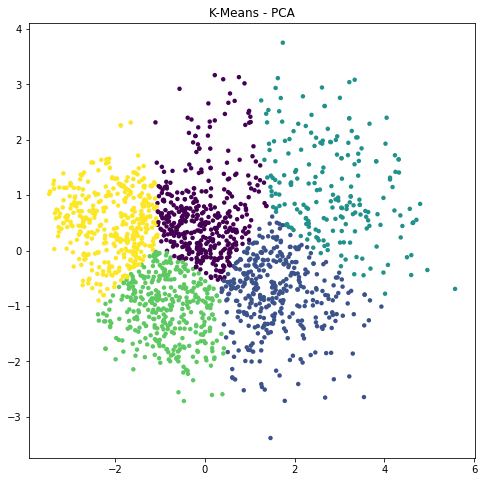

In [66]:
plt.figure(figsize=(8,8))
plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)
plt.title('K-Means - PCA')
plt.show()

Same process but on the tf-idf text represantation.

In [67]:
tfidf_data = cosine_similarity(tfidf_train_content)

C:\Users\dhyan\AppData\Local\Temp\ipykernel_20172\577812457.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)


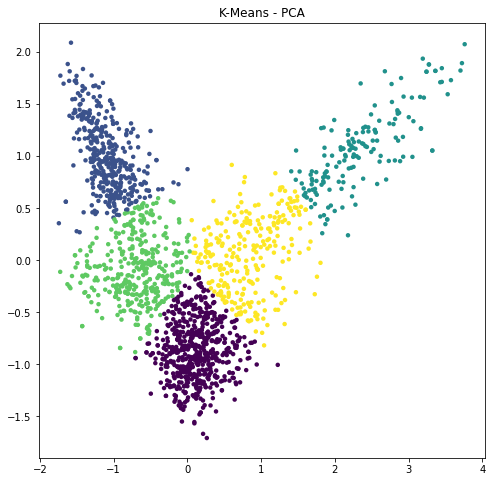

In [68]:
pca = PCA(n_components=2).fit(tfidf_data)
data2D = pca.transform(tfidf_data)
random_state = np.random.RandomState(0)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=3, random_state=random_state).fit(data2D)
plt.figure(figsize=(8,8))
plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)
plt.title('K-Means - PCA')
plt.show()